In [1]:
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
from scipy import integrate

In [2]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [3]:
lats = np.linspace(90, -90, 145)
lons = np.linspace(0, 358.75, 288)
#levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300,
         # 350, 400, 450, 500, 550, 600, 650, 700,
          #750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]

levels = [1,5,10,20,30,50,70,100,
        150,200,250,300,400,500,600,700,
        850,925,1000]

geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

In [4]:
ps_ds = xr.open_mfdataset('raw_monthly_data/anl_surf*.nc')

ps_ds = ps_ds.rename({'initial_time0_hours':'time',
                'g0_lat_1':'lat',
                'g0_lon_2':'lon',
                'PRES_GDS0_SFC_S123':'pres_surf'})

ps_ds = ps_ds.drop(['initial_time0','initial_time0_encoded'])

ps_ds

<xarray.Dataset>
Dimensions:    (time: 516, lat: 145, lon: 288)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * lat        (lat) float32 90.0 88.75 87.5 86.25 ... -86.25 -87.5 -88.75 -90.0
  * lon        (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    pres_surf  (time, lat, lon) float32 dask.array<chunksize=(12, 145, 288), meta=np.ndarray>
Attributes:
    creation_date:  Mon Oct 10 15:42:18 MDT 2022
    NCL_Version:    6.6.2
    system:         Linux casper34 3.10.0-1127.18.2.el7.x86_64 #1 SMP Sun Jul...
    Conventions:    None
    grib_source:    anl_surf125.001_pres.197901_197912.cox592632.grb
    title:          NCL: convert-GRIB-to-netCDF

In [31]:
#First get the weights

levels_array = np.array(levels)#[::-1]) #NOTE: WE flip the level array here
mlev = (levels_array[:-1] + levels_array[1:]) / 2
new_mlev = np.append(np.insert(mlev, 0, 0), 1000)
#Now we have the generic edges of our level boxes

WEIGHT = np.empty((len(levels), len(lats), len(lons)))
ps = ps_ds.pres_surf.mean('time').values / 100 #To get in hPa

for i in range(len(lats)):
    for j in range(len(lons)):
        
        #This looks and first makes sure that the level at each point is not below the surface pressure
        #If a point is below ths surface pressure, it gets converted to the surface pressure
        #Then we subtract out the original neighboring levels
        #This will result in some level boxes getting negative weight (where surface pressure was used)
        #So, we change those values to 0
        #Then we deal with converting hPa to Pa and making units work with g
        WEIGHT[:,i,j] = np.maximum(np.minimum(new_mlev[1:], ps[i,j] * np.ones(len(levels))) - new_mlev[:-1],
                                   np.zeros(len(levels))) * 100 / g

#This is our generic weighting, used later
weight = -(new_mlev[:-1] - new_mlev[1:]) * 100 / g

In [32]:
#This is basically just making a topography maks

tmask = np.ones((len(levels), len(lats), len(lons)))
TMASK = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        lon_idxs = np.where(ps[j,:] < new_mlev[i+1])

        tmask[i,j,lon_idxs] = 0
        TMASK[i,j,lon_idxs] = np.nan

764.525993883792


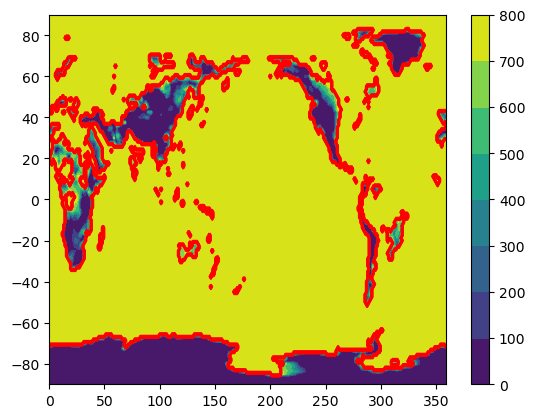

In [30]:
plt.contour(lons, lats, tmask[-2,:,:], colors='r')
plt.contourf(lons, lats, WEIGHT[-2,:,:])

print(weight[-2])

plt.colorbar()
plt.show()

### Decide below on partial levels

In [36]:
### To take away partial levels  ####

WEIGHT = WEIGHT * tmask

In [37]:
#This is the weighting for each point, allowing for us to take zonal averages more easily

ZON_NORM = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        ZON_NORM[i,j,:] = WEIGHT[i,j,:] / np.maximum(np.sum(WEIGHT[i,j,:]), 1e-5)

In [38]:
#And zonal weights, useful for AHT where we have zonal-mean quantities

ZON_WEIGHT = np.ones((len(levels), len(lats)))

for i in range(len(levels)):
    ZON_WEIGHT[i,:] = np.mean(WEIGHT[i,:,:], axis=1)

### Now, let's save out all the weighting info to a netcdf

In [39]:
WEIGHT_attrs = 'Weighting for each grid cell. Not normalized.'
weight_attrs = 'Generic weighting for the column. Does not account for surface pressure.'
TMASK_attrs = 'Simple mask where points are 1 if above time-mean surface pressure, or nan if below. Unitless.'
tmask_attrs = 'Simple mask where points are 1 if above time-mean surface pressure, or 0 if below. Unitless.'
ZON_NORM_attrs = 'Basically a normalized version of WEIGHT, where the normalization is over longitude. To take a zonal average, multiply a quantity by this and sum along the longitude dimenion. Unitless.'
ZON_WEIGHT_attrs = 'Zonal average weight.'

weighting_ds = xr.Dataset(
                    data_vars = dict(
                        WEIGHT=(['level','latitude','longitude'], WEIGHT, {'Description':WEIGHT_attrs, 'units':'kg/m^2'}),
                        weight=(['level'], weight, {'Description':weight_attrs, 'units':'kg/m^2'}),
                        TMASK=(['level','latitude','longitude'], TMASK, {'Description':TMASK_attrs, 'units':'Unitless'}),
                        tmask=(['level','latitude','longitude'], tmask, {'Description':tmask_attrs, 'units':'Unitless'}),
                        ZON_NORM=(['level','latitude','longitude'], ZON_NORM, {'Description':ZON_NORM_attrs, 'units':'Unitless'}),
                        ZON_WEIGHT=(['level','latitude'], ZON_WEIGHT, {'Description':ZON_WEIGHT_attrs, 'units':'kg/m^2'}),
                    ),
                    coords=dict(
                        level=levels[::-1],
                        latitude=lats,
                        longitude=lons)
)

#weighting_ds.to_netcdf('jra_aht_weights.nc')

### Load in the data

In [40]:
jra_data = xr.open_mfdataset('raw_monthly_data/jra_*.nc')

In [41]:
jra_data

,Array,Chunk
Bytes,3.04 GiB,5.89 MiB
Shape,"(528, 37, 145, 288)","(1, 37, 145, 288)"
Count,1584 Tasks,528 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.04 GiB,5.89 MiB
Shape,"(528, 37, 145, 288)","(1, 37, 145, 288)"
Count,1584 Tasks,528 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [42]:
jra_data = jra_data.interp(lev = levels)

In [43]:
jra_data

,Array,Chunk
Bytes,1.56 GiB,3.03 MiB
Shape,"(528, 19, 145, 288)","(1, 19, 145, 288)"
Count,3172 Tasks,528 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.56 GiB,3.03 MiB
Shape,"(528, 19, 145, 288)","(1, 19, 145, 288)"
Count,3172 Tasks,528 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Let's first make a near-surface MSE variable, we'll add this to the AHT ds at the end

In [13]:
jra_data['mse_surf'] = jra_data.temp * cp + jra_data.q * L

jra_mse_zonal = np.sum(jra_data.mse_surf * ZON_NORM[None,:,:,:], axis=3)

In [14]:
ZON_WEIGHT_normed = ZON_WEIGHT / np.amax(ZON_WEIGHT,axis=1)[:,None]

#Basically saying we need data for half the points at a lat/height to not nan it
ZON_WEIGHT_normed[ZON_WEIGHT_normed < .5] = np.nan

bottom_idxs = (~np.isnan(ZON_WEIGHT_normed)).cumsum(0).argmax(0)

In [15]:
jra_mse_zonal_values = jra_mse_zonal.values

In [16]:
jra_data_mse_surf = np.zeros((len(jra_data.time),len(lats)))

for i in range(len(lats)):
    jra_data_mse_surf[:,i] = jra_mse_zonal_values[:,bottom_idxs[i],i]

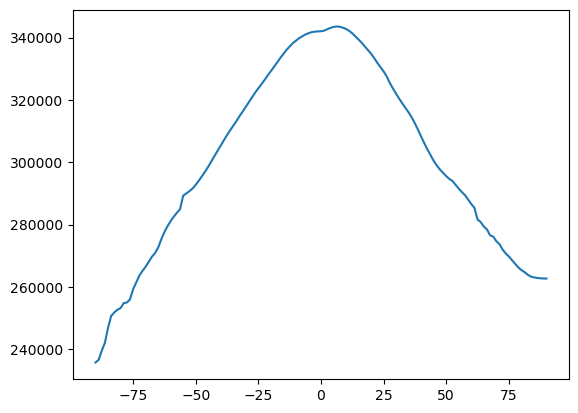

In [17]:
plt.plot(lats, np.mean(jra_data_mse_surf, axis=0))

plt.show()

### Now calculate AHT

In [44]:


def aht_jra(time_idx, correct_mass=True):
    
    WEIGHT_copy = copy.deepcopy(WEIGHT)
    
    #Load in the data and flip the level dimension, since we did this for the weighting too
    v = jra_data.vcomp.isel(time=time_idx).values#[::-1, :, :]
    t = jra_data.temp.isel(time=time_idx).values#[::-1, :, :]
    q = jra_data.q.isel(time=time_idx).values#[::-1, :, :]
    z = jra_data.height.isel(time=time_idx).values#[::-1, :, :]
    
    vt = jra_data.vt.isel(time=time_idx).values#[::-1, :, :]
    vq = jra_data.vq.isel(time=time_idx).values#[::-1, :, :]
    vz = jra_data.vz.isel(time=time_idx).values#[::-1, :, :]
    
    #For some reason, first 10 vertical levels of q are always nan
    #Effectively water vapor that high is 0 anyways, so let's just turn them to 0
    
    q[:10,:,:] = 0
    

    #Now get rid of nans everywhere
    WEIGHT_copy[np.isnan(v)] = 0
    WEIGHT_copy[np.isnan(t)] = 0
    WEIGHT_copy[np.isnan(q)] = 0
    WEIGHT_copy[np.isnan(z)] = 0

    v[np.isnan(v)] = 0
    t[np.isnan(t)] = 0
    q[np.isnan(q)] = 0
    z[np.isnan(z)] = 0
    vt[np.isnan(vt)] = 0
    vq[np.isnan(vq)] = 0
    vz[np.isnan(vz)] = 0

    #Convert everything to the same MSE units
    SE = cp * t
    PE = g * z
    ME = L * q
    MSE = SE + PE + ME
    
    #Find zonal-averages
    SE_bar = np.sum(ZON_NORM * SE, axis=2)
    ME_bar = np.sum(ZON_NORM * ME, axis=2)
    PE_bar = np.sum(ZON_NORM * PE, axis=2)
    V_bar = np.sum(ZON_NORM * v, axis=2)
    E_bar = np.sum(ZON_NORM * MSE, axis=2)

    #Then find zonal anomalies
    Ve = v - V_bar[:,:,None]
    SEe = SE - SE_bar[:,:,None]
    MEe = ME - ME_bar[:,:,None]
    PEe = PE - PE_bar[:,:,None]
    
    #Multiply zonal-anomalies to get the SE piece
    #_map is just referring to plan view, ie before zonal averaging occurs
    #Dividing the WEIGHT by weight, normalizes things
    VSEse_map = (Ve * SEe) * (WEIGHT_copy / weight[:,None,None])
    VMEse_map = (Ve * MEe) * (WEIGHT_copy / weight[:,None,None])
    VPEse_map = (Ve * PEe) * (WEIGHT_copy / weight[:,None,None])
    
    #Get the SEs
    VSEse_bar = np.mean(VSEse_map, axis=2)
    VMEse_bar = np.mean(VMEse_map, axis=2)
    VPEse_bar = np.mean(VPEse_map, axis=2)
    
    #Now do the TEs
    #So, follow same formula as SEs     
    VSEte_map = ((vt * cp) - (v * SE)) * (WEIGHT_copy / weight[:,None,None])
    VMEte_map = ((vq * L) - (v * ME)) * (WEIGHT_copy / weight[:,None,None])
    VPEte_map = ((vz * g) - (v * PE)) * (WEIGHT_copy / weight[:,None,None])

    VSEte_bar = np.mean(VSEte_map, axis=2)
    VMEte_bar = np.mean(VMEte_map, axis=2)
    VPEte_bar = np.mean(VPEte_map, axis=2)
        
    #Account for non-zero mass transport in the MMC by removing the vertically averaged v and MSE
    V_vert_ave = np.sum(V_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    E_vert_ave = np.sum(E_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    ME_vert_ave = np.sum(ME_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    PE_vert_ave = np.sum(PE_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    SE_vert_ave = np.sum(SE_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    
    if correct_mass == True:
        V_bar_new = V_bar - V_vert_ave[None,:]
        E_bar_new = E_bar - E_vert_ave[None,:]
        ME_bar_new = ME_bar - ME_vert_ave[None,:]
        PE_bar_new = PE_bar - PE_vert_ave[None,:]
        SE_bar_new = SE_bar - SE_vert_ave[None,:]
    elif correct_mass == False:
        V_bar_new = V_bar
        E_bar_new = E_bar
        ME_bar_new = ME_bar
        PE_bar_new = PE_bar
        SE_bar_new = SE_bar
    else:
        print('Error with specifying mass correction choice')
        
     
    #MASS = np.sum(ZON_WEIGHT * V_bar * E_vert_ave[None,:], axis=0)
    MASS = np.sum(ZON_WEIGHT, axis=0) * V_vert_ave * E_vert_ave

    #Now multiply things by the needed weights and sum in the vertical
    MMC = np.sum(ZON_WEIGHT * V_bar_new * E_bar_new, axis=0)
    strm_fnct = np.cumsum(ZON_WEIGHT * V_bar_new, axis=0)
    MMC_moist = np.sum(ZON_WEIGHT * V_bar_new * ME_bar_new, axis=0)
    MMC_dry = np.sum(ZON_WEIGHT * V_bar_new * SE_bar_new, axis=0)
    MMC_pot = np.sum(ZON_WEIGHT * V_bar_new * PE_bar_new, axis=0)
    
    #SEs and TEs have already accounted for surface orography, so we just use generic weight here
    SE_dry = np.sum(weight[:,None] * VSEse_bar, axis=0)
    SE_pot = np.sum(weight[:,None] * VPEse_bar, axis=0)
    SE_moist = np.sum(weight[:,None] * VMEse_bar, axis=0)
    
    SE = SE_dry + SE_pot + SE_moist
    
    TE_dry = np.sum(weight[:,None] * VSEte_bar, axis=0)
    TE_pot = np.sum(weight[:,None] * VPEte_bar, axis=0)
    TE_moist = np.sum(weight[:,None] * VMEte_bar, axis=0)
    
    TE = TE_dry + TE_pot + TE_moist
    
    return MMC, MMC_moist, MMC_dry, MMC_pot, SE, SE_moist, SE_dry, SE_pot, TE, TE_moist, TE_dry, TE_pot, MASS, strm_fnct, VSEse_bar, VPEse_bar, VMEse_bar, VSEte_bar, VPEte_bar, VMEte_bar, E_bar_new, V_bar_new, SE_bar_new, PE_bar_new, ME_bar_new



In [45]:
num_months = len(jra_data.time)

TEs = np.zeros((num_months, len(lats)))
TEs_moist = np.zeros((num_months, len(lats)))
TEs_dry = np.zeros((num_months, len(lats)))
TEs_pot = np.zeros((num_months, len(lats)))
SEs = np.zeros((num_months, len(lats)))
SEs_moist = np.zeros((num_months, len(lats)))
SEs_dry = np.zeros((num_months, len(lats)))
SEs_pot = np.zeros((num_months, len(lats)))
MMCs = np.zeros((num_months, len(lats)))
MMCs_moist = np.zeros((num_months, len(lats)))
MMCs_dry = np.zeros((num_months, len(lats)))
MMCs_pot = np.zeros((num_months, len(lats)))
MASSs = np.zeros((num_months, len(lats)))
strm_fncts = np.zeros((num_months, len(levels), len(lats)))
VSEses = np.zeros((num_months, len(levels), len(lats)))
VPEses = np.zeros((num_months, len(levels), len(lats)))
VMEses = np.zeros((num_months, len(levels), len(lats)))
VSEtes = np.zeros((num_months, len(levels), len(lats)))
VPEtes = np.zeros((num_months, len(levels), len(lats)))
VMEtes = np.zeros((num_months, len(levels), len(lats)))
V_bars = np.zeros((num_months, len(levels), len(lats)))
E_bars = np.zeros((num_months, len(levels), len(lats)))
SE_bars = np.zeros((num_months, len(levels), len(lats)))
PE_bars = np.zeros((num_months, len(levels), len(lats)))
ME_bars = np.zeros((num_months, len(levels), len(lats)))

for i in range(num_months):
    values = aht_jra(i)
    MMCs[i,:] = values[0]
    MMCs_moist[i,:] = values[1]
    MMCs_dry[i,:] = values[2]
    MMCs_pot[i,:] = values[3]
    
    SEs[i,:] = values[4]
    SEs_moist[i,:] = values[5]
    SEs_dry[i,:] = values[6]
    SEs_pot[i,:] = values[7]
    
    TEs[i,:] = values[8]
    TEs_moist[i,:] = values[9]
    TEs_dry[i,:] = values[10]
    TEs_pot[i,:] = values[11]
    
    MASSs[i,:] = values[12]
    
    strm_fncts[i,:,:] = values[13]
    
    VSEses[i,:,:] = values[14]
    VPEses[i,:,:] = values[15]
    VMEses[i,:,:] = values[16]
    
    VSEtes[i,:,:] = values[17]
    VPEtes[i,:,:] = values[18]
    VMEtes[i,:,:] = values[19]
    
    V_bars[i,:,:] = values[20]
    E_bars[i,:,:] = values[21]
    SE_bars[i,:,:] = values[22]
    PE_bars[i,:,:] = values[23]
    ME_bars[i,:,:] = values[24]
    

In [46]:
TOTs = MMCs + SEs + TEs
TOTs_moist = MMCs_moist + SEs_moist + TEs_moist
TOTs_dry = MMCs_dry + SEs_dry + TEs_dry
TOTs_pot = MMCs_pot + SEs_pot + TEs_pot
TOTs_dry_pot = TOTs_dry + TOTs_pot

TEs_dry_pot = TEs_dry + TEs_pot
SEs_dry_pot = SEs_dry + SEs_pot
MMCs_dry_pot = MMCs_dry + MMCs_pot

EDDYs = SEs + TEs
EDDYs_moist = SEs_moist + TEs_moist
EDDYs_dry = SEs_dry + TEs_dry
EDDYs_pot = SEs_pot + TEs_pot
EDDYs_dry_pot = EDDYs_dry + EDDYs_pot

In [47]:
final_ds = xr.Dataset(
                    data_vars = dict(
                        total_aht=(['time','latitude'], TOTs * (geometry * g)[None,:]),
                        total_aht_dry=(['time','latitude'], TOTs_dry * (geometry * g)[None,:]),
                        total_aht_moist=(['time','latitude'], TOTs_moist * (geometry * g)[None,:]),
                        total_aht_pot=(['time','latitude'], TOTs_pot * (geometry * g)[None,:]),
                        total_aht_dry_pot=(['time','latitude'], TOTs_dry_pot * (geometry * g)[None,:]),
                        mmc_aht=(['time','latitude'], MMCs * (geometry * g)[None,:]),
                        mmc_aht_dry=(['time','latitude'], MMCs_dry * (geometry * g)[None,:]),
                        mmc_aht_moist=(['time','latitude'], MMCs_moist * (geometry * g)[None,:]),
                        mmc_aht_pot=(['time','latitude'], MMCs_pot * (geometry * g)[None,:]),
                        mmc_aht_dry_pot=(['time','latitude'], MMCs_dry_pot * (geometry * g)[None,:]),
                        se_aht=(['time','latitude'], SEs * (geometry * g)[None,:]),
                        se_aht_dry=(['time','latitude'], SEs_dry * (geometry * g)[None,:]),
                        se_aht_moist=(['time','latitude'], SEs_moist * (geometry * g)[None,:]),
                        se_aht_pot=(['time','latitude'], SEs_pot * (geometry * g)[None,:]),
                        se_aht_dry_pot=(['time','latitude'], SEs_dry_pot * (geometry * g)[None,:]),
                        te_aht=(['time','latitude'], TEs * (geometry * g)[None,:]),
                        te_aht_dry=(['time','latitude'], TEs_dry * (geometry * g)[None,:]),
                        te_aht_moist=(['time','latitude'], TEs_moist * (geometry * g)[None,:]),
                        te_aht_pot=(['time','latitude'], TEs_pot * (geometry * g)[None,:]),
                        te_aht_dry_pot=(['time','latitude'], TEs_dry_pot * (geometry * g)[None,:]),
                        eddy_aht=(['time','latitude'], EDDYs * (geometry * g)[None,:]),
                        eddy_aht_dry=(['time','latitude'], EDDYs_dry * (geometry * g)[None,:]),
                        eddy_aht_moist=(['time','latitude'], EDDYs_moist * (geometry * g)[None,:]),
                        eddy_aht_pot=(['time','latitude'], EDDYs_pot * (geometry * g)[None,:]),
                        eddy_aht_dry_pot=(['time','latitude'], EDDYs_dry_pot * (geometry * g)[None,:]),
                        mass=(['time','latitude'], MASSs * (geometry * g)[None,:]),
                        #mse_surf=(['time','latitude'], jra_data_mse_surf),
                        strm_fnct=(['time','level','latitude'], strm_fncts * g * geometry[None,None,:]),
                        VSEse=(['time','level','latitude'], VSEses * 1000 * g**2 * geometry[None,None,:]),
                        VPEse=(['time','level','latitude'], VPEses * 1000 * g**2 * geometry[None,None,:]),
                        VMEse=(['time','level','latitude'], VMEses * 1000 * g**2 * geometry[None,None,:]),
                        VSEte=(['time','level','latitude'], VSEtes * 1000 * g**2 * geometry[None,None,:]),
                        VPEte=(['time','level','latitude'], VPEtes * 1000 * g**2 * geometry[None,None,:]),
                        VMEte=(['time','level','latitude'], VMEtes * 1000 * g**2 * geometry[None,None,:]),
                        V_bar=(['time','level','latitude'], V_bars),
                        E_bar=(['time','level','latitude'], E_bars),
                        ME_bar=(['time','level','latitude'], ME_bars),
                        PE_bar=(['time','level','latitude'], PE_bars),
                        SE_bar=(['time','level','latitude'], SE_bars),
                    ),
                    coords=dict(
                        time=jra_data.time,
                        level=levels,
                        latitude=lats,)
)

#final_ds.to_netcdf('jra_aht_19_levels.nc')

In [49]:
full_19_ds = xr.open_dataset('jra_aht_19_levels.nc')

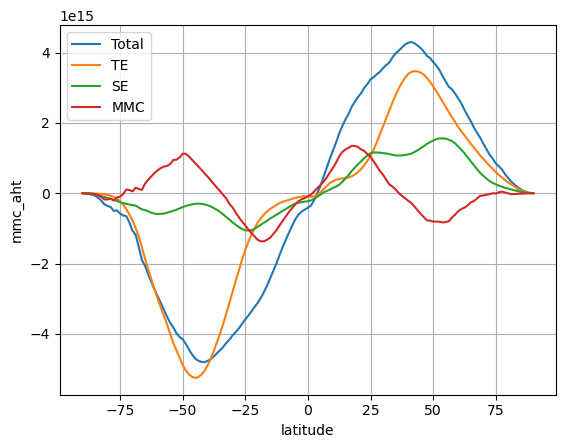

In [50]:
(final_ds.total_aht.mean('time')).plot(label='Total')
(final_ds.te_aht.mean('time')).plot(label='TE')
(final_ds.se_aht.mean('time')).plot(label='SE')
(final_ds.mmc_aht.mean('time')).plot(label='MMC')

plt.grid()

plt.legend(loc=0)

plt.show()

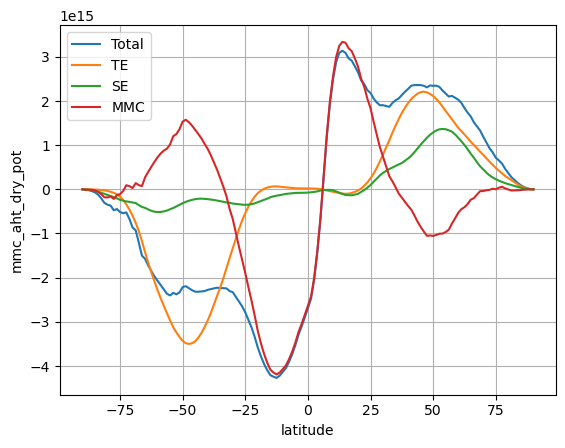

In [51]:
(final_ds.total_aht_dry_pot.mean('time')).plot(label='Total')
(final_ds.te_aht_dry_pot.mean('time')).plot(label='TE')
(final_ds.se_aht_dry_pot.mean('time')).plot(label='SE')
(final_ds.mmc_aht_dry_pot.mean('time')).plot(label='MMC')

plt.grid()

plt.legend(loc=0)

plt.show()

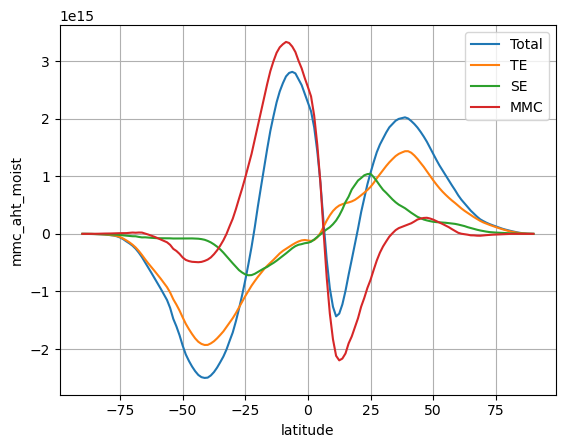

In [52]:
(final_ds.total_aht_moist.mean('time')).plot(label='Total')
(final_ds.te_aht_moist.mean('time')).plot(label='TE')
(final_ds.se_aht_moist.mean('time')).plot(label='SE')
(final_ds.mmc_aht_moist.mean('time')).plot(label='MMC')

plt.grid()

plt.legend(loc=0)

plt.show()

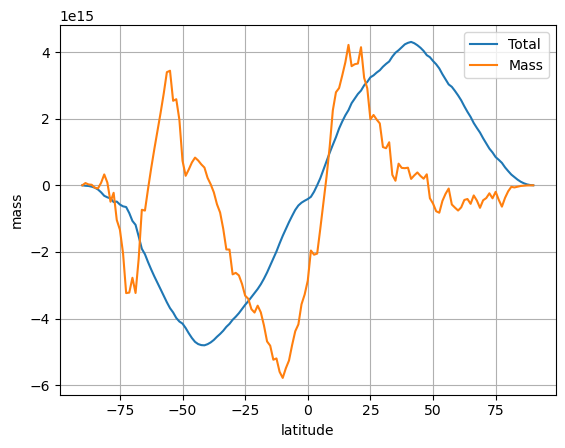

In [53]:
(final_ds.total_aht.mean('time')).plot(label='Total')
((final_ds.mass).mean('time')).plot(label='Mass')


plt.grid()

plt.legend(loc=0)

plt.show()

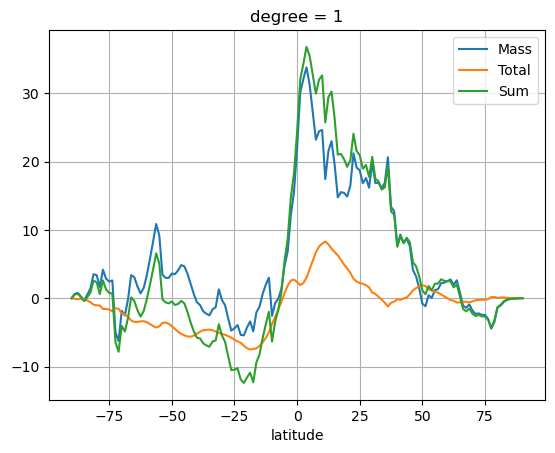

In [54]:
trends_ds = final_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
(trends_ds.mass_polyfit_coefficients.sel(degree=1) / 1e12).plot(label='Mass')
(trends_ds.total_aht_polyfit_coefficients.sel(degree=1) / 1e12).plot(label='Total')

((trends_ds.total_aht_polyfit_coefficients + trends_ds.mass_polyfit_coefficients).sel(degree=1) / 1e12).plot(label='Sum')
plt.legend(loc=0)
plt.grid()
plt.show()

In [63]:
# Compare against the original

orig_ds = xr.open_dataset('jra_aht.nc')
orig_trends_ds = orig_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)

orig_no_partial_ds = xr.open_dataset('jra_aht_no_partial_levels.nc')
orig_no_partial_trends_ds = orig_no_partial_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)

No handles with labels found to put in legend.


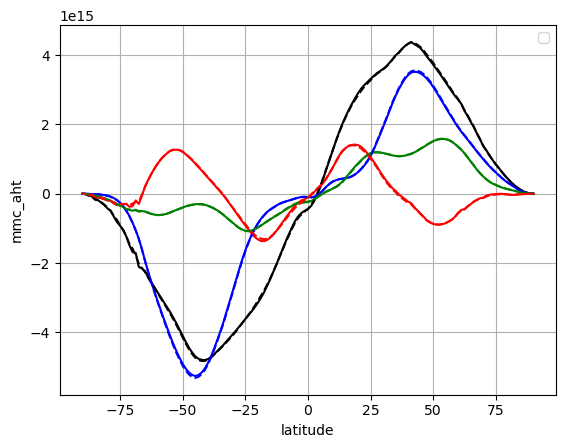

In [65]:
(full_19_ds.total_aht.mean('time')).plot( color='k')
(full_19_ds.te_aht.mean('time')).plot( color='b')
(full_19_ds.se_aht.mean('time')).plot( color='g')
(full_19_ds.mmc_aht.mean('time')).plot( color='r')

(orig_ds.total_aht.mean('time')).plot(linestyle='--', color='k')
(orig_ds.te_aht.mean('time')).plot(linestyle='--', color='b')
(orig_ds.se_aht.mean('time')).plot(linestyle='--', color='g')
(orig_ds.mmc_aht.mean('time')).plot(linestyle='--', color='r')





plt.grid()

plt.legend(loc=0)

#plt.savefig('../figures/Nov_22/jra_mean_aht_19_levs_comparison')
plt.show()

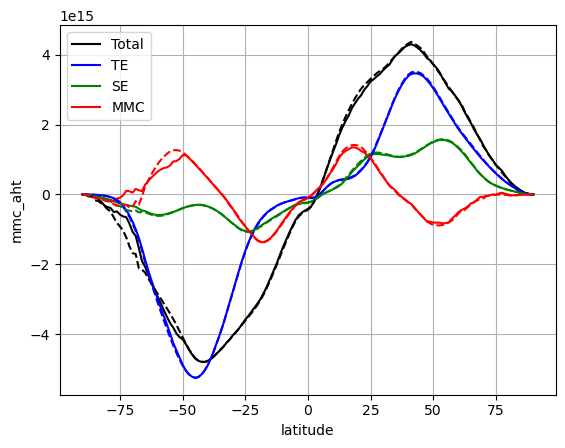

No handles with labels found to put in legend.


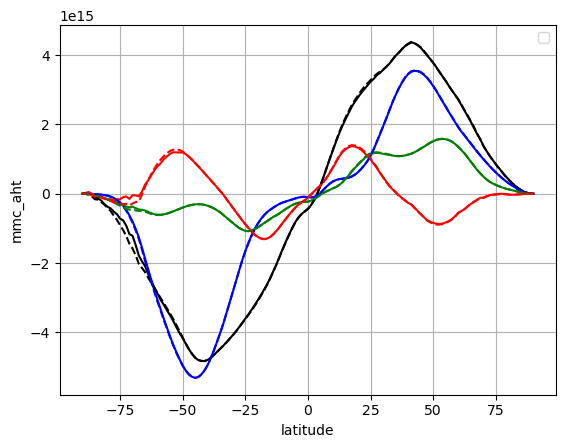

In [64]:
(final_ds.total_aht.mean('time')).plot(color='k', label='Total')
(final_ds.te_aht.mean('time')).plot(color='b', label='TE')
(final_ds.se_aht.mean('time')).plot(color='g', label='SE')
(final_ds.mmc_aht.mean('time')).plot(color='r', label='MMC')

(full_19_ds.total_aht.mean('time')).plot(linestyle='--', color='k')
(full_19_ds.te_aht.mean('time')).plot(linestyle='--', color='b')
(full_19_ds.se_aht.mean('time')).plot(linestyle='--', color='g')
(full_19_ds.mmc_aht.mean('time')).plot(linestyle='--', color='r')


plt.grid()

plt.legend(loc=0)

#plt.savefig('../figures/Nov_22/jra_mean_aht_19_levs_comparison')
plt.show()

(orig_no_partial_ds.total_aht.mean('time')).plot( color='k')
(orig_no_partial_ds.te_aht.mean('time')).plot( color='b')
(orig_no_partial_ds.se_aht.mean('time')).plot( color='g')
(orig_no_partial_ds.mmc_aht.mean('time')).plot( color='r')

(orig_ds.total_aht.mean('time')).plot(linestyle='--', color='k')
(orig_ds.te_aht.mean('time')).plot(linestyle='--', color='b')
(orig_ds.se_aht.mean('time')).plot(linestyle='--', color='g')
(orig_ds.mmc_aht.mean('time')).plot(linestyle='--', color='r')

plt.grid()

plt.legend(loc=0)

#plt.savefig('../figures/Nov_22/jra_mean_aht_19_levs_comparison')
plt.show()

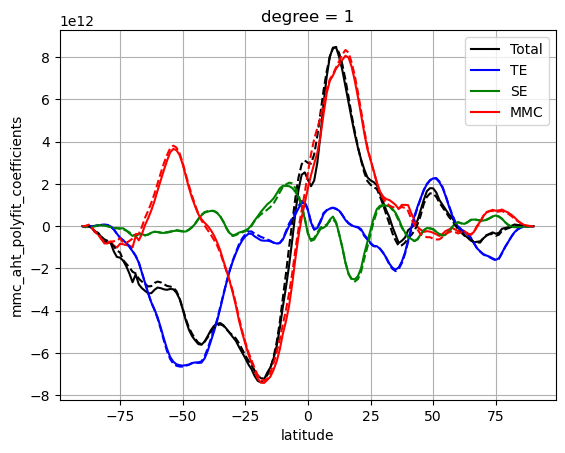

In [43]:
(trends_ds.total_aht_polyfit_coefficients.sel(degree=1)).plot(color='k', label='Total')
(trends_ds.te_aht_polyfit_coefficients.sel(degree=1)).plot(color='b', label='TE')
(trends_ds.se_aht_polyfit_coefficients.sel(degree=1)).plot(color='g', label='SE')
(trends_ds.mmc_aht_polyfit_coefficients.sel(degree=1)).plot(color='r', label='MMC')

(orig_trends_ds.total_aht_polyfit_coefficients.sel(degree=1)).plot(linestyle='--', color='k')
(orig_trends_ds.te_aht_polyfit_coefficients.sel(degree=1)).plot(linestyle='--', color='b')
(orig_trends_ds.se_aht_polyfit_coefficients.sel(degree=1)).plot(linestyle='--', color='g')
(orig_trends_ds.mmc_aht_polyfit_coefficients.sel(degree=1)).plot(linestyle='--', color='r')

plt.grid()

plt.legend(loc=0)

#plt.savefig('../figures/Nov_22/jra_trends_aht_19_levs_comparison')
plt.show()

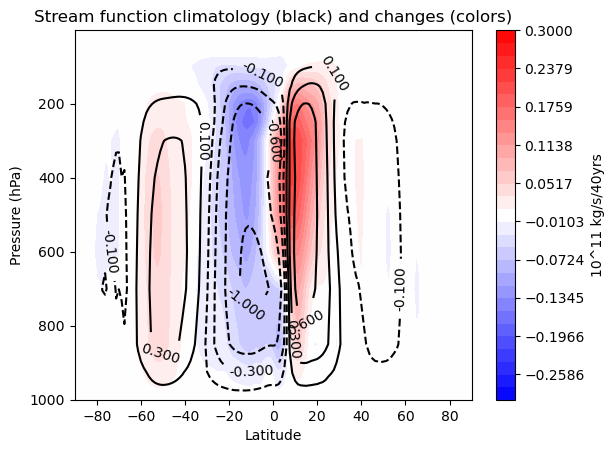

In [36]:
clima_strm = final_ds.strm_fnct.mean(['time'])

which_levels = [-2.5, -2.0, -1.5, -1.0, -.6, -.3, -.1, .1, .3, .6, 1.0, 1.5, 2.0, 2.5]
#which_levels = range(-15, 16)
#which_levels = [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,
                #1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
cont=plt.contour(lats, levels, clima_strm/1e11, levels=which_levels, colors='k')

contf = plt.contourf(lats, levels, trends_ds.strm_fnct_polyfit_coefficients.sel(degree=1) * 40/1e11,
                     levels=np.linspace(-.3, .3, 30), cmap='bwr')

plt.colorbar(contf, label='10^11 kg/s/40yrs')

plt.gca().invert_yaxis()

def fmt(x):
    #rounded = f"{x:-2f}"
    rounded = f"{x:1f}"
    return rounded

#plt.clabel(cont, cont.levels, inline=True, fmt='%2.f', fontsize=10)
plt.clabel(cont, cont.levels, inline=True,  fontsize=10)

#plt.axhline(700)
#plt.axvline(-12)

#plt.xlim([-50, 50])
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')

plt.title('Stream function climatology (black) and changes (colors)')

#plt.savefig('../figures/aht_trends/jra_stream_function_clima_and_changes')

plt.show()

In [166]:
def trend(x):
    return x.polyfit('time', deg=1)

jra_month = final_ds.groupby('time.month').mean('time')

#Output is in W/ns, so we convert to PW/40yrs
jra_trends_month = final_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40

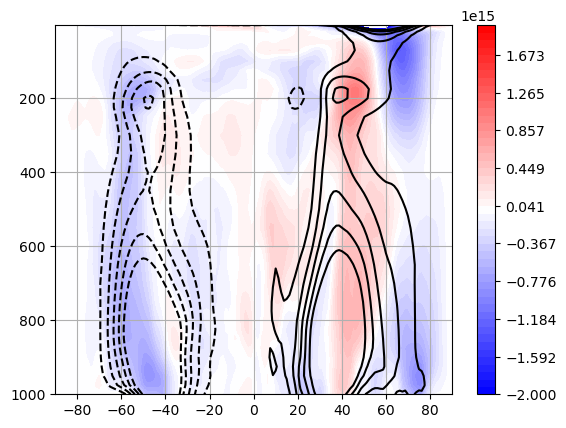

In [168]:
which_month = 2
te_tot = jra_month.VSEte + jra_month.VPEte + jra_month.VMEte
se_tot = jra_month.VSEse + jra_month.VPEse + jra_month.VMEse

eddy_tot = se_tot + te_tot

te_tot_trend = jra_trends_month.VSEte_polyfit_coefficients + jra_trends_month.VPEte_polyfit_coefficients + jra_trends_month.VMEte_polyfit_coefficients
se_tot_trend = jra_trends_month.VSEse_polyfit_coefficients + jra_trends_month.VPEse_polyfit_coefficients + jra_trends_month.VMEse_polyfit_coefficients

eddy_tot_trend = se_tot_trend + te_tot_trend

plt.contour(lats, levels, te_tot.sel(month=which_month) / 1e15,
             levels=[ -5, -4, -3, -2, -1, 1, 2, 3, 4, 5], colors='k')

plt.contourf(lats, levels, te_tot_trend.sel(degree=1).sel(month=which_month),
             levels=np.linspace(-2e15, 2e15, 50), cmap='bwr')

plt.colorbar()

plt.gca().invert_yaxis()

plt.grid()

plt.show()

In [183]:
def cumtrapz(A, dim):
    """Cumulative Simpson's rule (aka Tai's method)

    Notes
    -----
    Simpson rule is given by
        int f (x) = sum (f_i+f_i+1) dx / 2
    """
    x = A[dim]
    dx = x - x.shift(**{dim:1})
    dx = dx.fillna(0.0)
    return ((A.shift(**{dim:1}) + A)*dx/2.0)\
          .fillna(0.0)\
          .cumsum(dim)

In [201]:
ps_ds_zon = ps_ds.pres_surf.mean('lon')
ps_ds_zon_no_mean = ps_ds_zon - ps_ds_zon.mean('lat')

In [202]:
ps_trend = ps_ds_zon_no_mean.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)

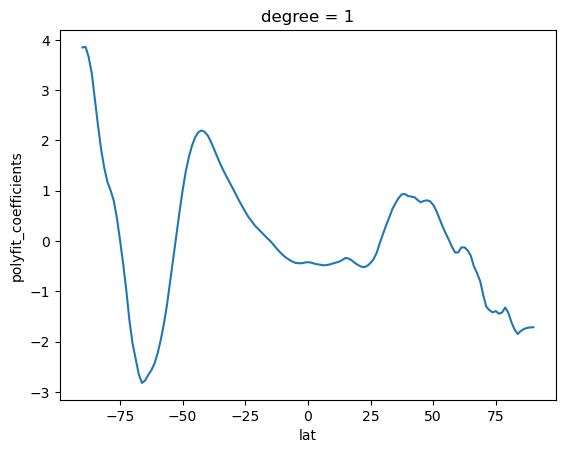

In [203]:
ps_trend.polyfit_coefficients.sel(degree=1).plot()
plt.show()

In [212]:
ps_trend_int = cumtrapz(ps_trend.polyfit_coefficients.sel(degree=1), 'lat')
ps_int2 = cumtrapz(ps_ds_zon_no_mean, 'lat')

ps_int_trend = ps_int2.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)

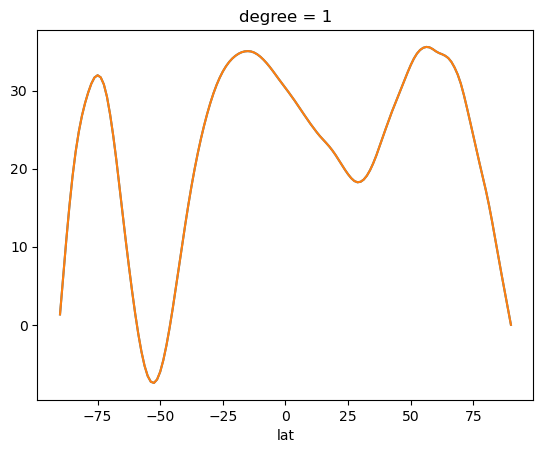

In [213]:
#(ps_int2.mean('time') * geometry).plot()
(ps_int_trend.polyfit_coefficients.sel(degree=1)).plot()
(ps_trend_int).plot()
plt.show()